In [7]:
# Import packages

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from get_data import (
    get_users_data,
    get_items_data,
    get_rating_base_data,
    get_rating_test_data,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import tensorflow.compat.v1 as tf


In [29]:
def preprocess_data(userGroup, movies_df):
    """
    Format the data for input and output into the RBM
    :param userGroup: data frame that stores user groups
    :param movies_df: data frame that stores movies information
    :return: user ratings normalized into a list - trX
    """
    # No. of users in training
    UsedUsers = 1000
    # create list
    trX = []
    # for each user in the group
    for userID, curUser in userGroup:
        # Temp variable that stores every movie's rating
        temp = [0] * len(movies_df)
        # For Each movie in the curUser's movie list
        for num, movie in curUser.iterrows():
            # Divide ratings by 5 and store it
            temp[movie['List Index']] = movie['rating'] / 5.0

        # Now add the list of ratings into the training list
        trX.append(temp)
        # Check to see if we finished adding in the amount of users for training
        if UsedUsers == 0:
            break
        UsedUsers -= 1
    return trX

In [34]:
def rbm(movies_df, FLAGS):
    """
    Implement RBM architecture in TensorFlow
    :param movies_df: data frame that stores movies information
    :param FLAGS: variable to store hyper-parameters
    :return: variables to be used during TensorFlow training
    """
    FLAGS.n_hid = 100  # Number of hidden layers
    FLAGS.n_vis = len(movies_df)  # Number of visible layers

    # Create respective placeholder variables for storing visible and hidden layer biases and weights
    vb = tf.placeholder("float", [FLAGS.n_vis])  # Number of unique movies
    hb = tf.placeholder("float", [FLAGS.n_hid])  # Number of features
    W = tf.placeholder("float", [FLAGS.n_vis, FLAGS.n_hid])  # Weights that connect the hidden and visible layers

    # Pre-process the input data
    v0 = tf.placeholder("float", [None, FLAGS.n_vis])
    _h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

    # Reconstruct the pre-processed input data (Sigmoid and ReLU activation functions are used)
    _v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
    v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
    h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

    # Set RBM training parameters
    alpha = 0.1  # Set learning rate
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)  # Set positive gradients
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)  # Set negative gradients

    # Calculate contrastive divergence to maximize
    CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

    # Create methods to update the weights and biases
    update_w = W + alpha * CD
    update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
    update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

    # Set error function (RMSE)
    err = v0 - v1
    err_sum = tf.sqrt(tf.reduce_mean(err**2))

    # Initialize variables
    cur_w = np.zeros([FLAGS.n_vis, FLAGS.n_hid], np.float32)  # Current weight
    cur_vb = np.zeros([FLAGS.n_vis], np.float32)  # Current visible unit biases
    cur_hb = np.zeros([FLAGS.n_hid], np.float32)  # Current hidden unit biases
    prv_w = np.zeros([FLAGS.n_vis, FLAGS.n_hid], np.float32)  # Previous weight
    prv_vb = np.zeros([FLAGS.n_vis], np.float32)  # Previous visible unit biases
    prv_hb = np.zeros([FLAGS.n_hid], np.float32)  # Previous hidden unit biases

    return v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum


In [8]:
# Disable the default activate eager execution in TF v1.0
tf.disable_eager_execution()

# Path directory
path = './ml-100k'
# Load data set from MovieLens1M
# movies_df = pd.read_csv(path + '/movies.dat', sep='::', header=None, engine='python', encoding='latin-1')
# ratings_df = pd.read_csv(path + '/ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')

In [9]:
movies_df = get_items_data()
movies_df

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,filmNoir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
ratings_df = get_rating_base_data()

In [12]:
# Create a separate indexing column as we cannot use MovieID
movies_df['List Index'] = movies_df.index

In [17]:
# Merge movies with ratings by MovieID as foreign key
merged_df = movies_df.merge(ratings_df, on='movie_id')

In [18]:
merged_df

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Mystery,Romance,SciFi,Thriller,War,Western,List Index,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,5,4,875635748
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,6,4,883599478
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,10,4,877888877
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,15,1,879455635
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,17,4,885272579
5,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,18,5,880130802
6,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,20,3,879667963
7,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,21,5,874951244
8,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,23,5,874784615
9,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,25,5,885853415


In [20]:
# Drop columns
merged_df = merged_df.drop('timestamp', axis=1).drop([
        "movie_title",
        "release_date",
        "video_release_date",
        "imdb_url",
        "unknown",
        "Action",
        "Adventure",
        "Animation",
        "Children's",
        "Comedy",
        "Crime",
        "Documentary",
        "Drama",
        "Fantasy",
        "filmNoir",
        "Horror",
        "Musical",
        "Mystery",
        "Romance",
        "SciFi",
        "Thriller",
        "War",
        "Western"        
    ], axis=1)

In [25]:
# Get user groups
userGroup = merged_df.groupby('user_id')

In [30]:
# Return normalized user ratings into a list
trX = preprocess_data(userGroup, movies_df)

In [36]:
import sys
sys.argv = sys.argv[:1]
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
del_all_flags(tf.flags.FLAGS)

tf.app.flags.DEFINE_integer('n_vis', 943,
                            'Number of visible neurons (Number of movies the users rated.)')

tf.app.flags.DEFINE_integer('n_hid', 200,
                            'Number of hidden neurons.')
tf.app.flags.DEFINE_integer('num_epoch', 50,
                            'Number of training epochs.')

tf.app.flags.DEFINE_integer('batch_size', 64,
                            'Size of the training batch.')

FLAGS = tf.app.flags.FLAGS

In [35]:
# Return variables from the RBM implementation
v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum = rbm(movies_df, FLAGS)


Instructions for updating:
Use `tf.cast` instead.


In [39]:
# Initialize TensorFlow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

errors = []
log = []

In [40]:
for i in range(FLAGS.num_epoch):
    print("Current epoch: ", i)
    for start, end in zip(range(0, len(trX), FLAGS.batch_size), range(FLAGS.batch_size, len(trX), FLAGS.batch_size)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print("Current RMSE error: ", errors[-1])
    log.append({"Train RMSE": errors[-1]})

Current epoch:  0
Current RMSE error:  0.28227103
Current epoch:  1
Current RMSE error:  0.2528583
Current epoch:  2
Current RMSE error:  0.24203068
Current epoch:  3
Current RMSE error:  0.23526978
Current epoch:  4
Current RMSE error:  0.23184097
Current epoch:  5
Current RMSE error:  0.22786677
Current epoch:  6
Current RMSE error:  0.22724672
Current epoch:  7
Current RMSE error:  0.22464809
Current epoch:  8
Current RMSE error:  0.22334577
Current epoch:  9
Current RMSE error:  0.22128177
Current epoch:  10
Current RMSE error:  0.2200085
Current epoch:  11
Current RMSE error:  0.21835658
Current epoch:  12
Current RMSE error:  0.21771492
Current epoch:  13
Current RMSE error:  0.21668825
Current epoch:  14
Current RMSE error:  0.21538873
Current epoch:  15
Current RMSE error:  0.21466511
Current epoch:  16
Current RMSE error:  0.21429238
Current epoch:  17
Current RMSE error:  0.21420233
Current epoch:  18
Current RMSE error:  0.21322468
Current epoch:  19
Current RMSE error:  0.2

Current RMSE error:  0.18560915
Current epoch:  161
Current RMSE error:  0.1848307
Current epoch:  162
Current RMSE error:  0.18489377
Current epoch:  163
Current RMSE error:  0.18437473
Current epoch:  164
Current RMSE error:  0.18475665
Current epoch:  165
Current RMSE error:  0.18513164
Current epoch:  166
Current RMSE error:  0.1843443
Current epoch:  167
Current RMSE error:  0.18405132
Current epoch:  168
Current RMSE error:  0.18441166
Current epoch:  169
Current RMSE error:  0.18396156
Current epoch:  170
Current RMSE error:  0.1847819
Current epoch:  171
Current RMSE error:  0.18358348
Current epoch:  172
Current RMSE error:  0.18378839
Current epoch:  173
Current RMSE error:  0.18391596
Current epoch:  174
Current RMSE error:  0.18365902
Current epoch:  175
Current RMSE error:  0.18376781
Current epoch:  176
Current RMSE error:  0.183544
Current epoch:  177
Current RMSE error:  0.18404926
Current epoch:  178
Current RMSE error:  0.18328929
Current epoch:  179
Current RMSE erro

Current RMSE error:  0.17298737
Current epoch:  319
Current RMSE error:  0.17305407
Current epoch:  320
Current RMSE error:  0.1732827
Current epoch:  321
Current RMSE error:  0.17313783
Current epoch:  322
Current RMSE error:  0.17370461
Current epoch:  323
Current RMSE error:  0.17309377
Current epoch:  324
Current RMSE error:  0.17366976
Current epoch:  325
Current RMSE error:  0.17308211
Current epoch:  326
Current RMSE error:  0.17277768
Current epoch:  327
Current RMSE error:  0.17319864
Current epoch:  328
Current RMSE error:  0.17333691
Current epoch:  329
Current RMSE error:  0.17279339
Current epoch:  330
Current RMSE error:  0.17236742
Current epoch:  331
Current RMSE error:  0.17245847
Current epoch:  332
Current RMSE error:  0.17312983
Current epoch:  333
Current RMSE error:  0.17221116
Current epoch:  334
Current RMSE error:  0.17248333
Current epoch:  335
Current RMSE error:  0.17230377
Current epoch:  336
Current RMSE error:  0.17240472
Current epoch:  337
Current RMSE 

Current RMSE error:  0.16737215
Current epoch:  477
Current RMSE error:  0.1672395
Current epoch:  478
Current RMSE error:  0.16759726
Current epoch:  479
Current RMSE error:  0.16719727
Current epoch:  480
Current RMSE error:  0.16714899
Current epoch:  481
Current RMSE error:  0.1673179
Current epoch:  482
Current RMSE error:  0.16688664
Current epoch:  483
Current RMSE error:  0.16709128
Current epoch:  484
Current RMSE error:  0.16725759
Current epoch:  485
Current RMSE error:  0.16631788
Current epoch:  486
Current RMSE error:  0.16694179
Current epoch:  487
Current RMSE error:  0.16691914
Current epoch:  488
Current RMSE error:  0.1666863
Current epoch:  489
Current RMSE error:  0.1670377
Current epoch:  490
Current RMSE error:  0.16685152
Current epoch:  491
Current RMSE error:  0.16684622
Current epoch:  492
Current RMSE error:  0.1667143
Current epoch:  493
Current RMSE error:  0.16668442
Current epoch:  494
Current RMSE error:  0.16719615
Current epoch:  495
Current RMSE erro

Current RMSE error:  0.1634582
Current epoch:  636
Current RMSE error:  0.1632382
Current epoch:  637
Current RMSE error:  0.16385539
Current epoch:  638
Current RMSE error:  0.1632602
Current epoch:  639
Current RMSE error:  0.1635041
Current epoch:  640
Current RMSE error:  0.16328724
Current epoch:  641
Current RMSE error:  0.16317602
Current epoch:  642
Current RMSE error:  0.1630647
Current epoch:  643
Current RMSE error:  0.16317484
Current epoch:  644
Current RMSE error:  0.16321966
Current epoch:  645
Current RMSE error:  0.16311997
Current epoch:  646
Current RMSE error:  0.1634366
Current epoch:  647
Current RMSE error:  0.16277756
Current epoch:  648
Current RMSE error:  0.16392002
Current epoch:  649
Current RMSE error:  0.1633463
Current epoch:  650
Current RMSE error:  0.16287358
Current epoch:  651
Current RMSE error:  0.16334862
Current epoch:  652
Current RMSE error:  0.16302796
Current epoch:  653
Current RMSE error:  0.16391078
Current epoch:  654
Current RMSE error:

Current RMSE error:  0.16105181
Current epoch:  795
Current RMSE error:  0.16011426
Current epoch:  796
Current RMSE error:  0.16078147
Current epoch:  797
Current RMSE error:  0.16130607
Current epoch:  798
Current RMSE error:  0.16144946
Current epoch:  799
Current RMSE error:  0.16099896
Current epoch:  800
Current RMSE error:  0.16081128
Current epoch:  801
Current RMSE error:  0.16049144
Current epoch:  802
Current RMSE error:  0.16133851
Current epoch:  803
Current RMSE error:  0.16109096
Current epoch:  804
Current RMSE error:  0.16070616
Current epoch:  805
Current RMSE error:  0.16060375
Current epoch:  806
Current RMSE error:  0.16052404
Current epoch:  807
Current RMSE error:  0.16070656
Current epoch:  808
Current RMSE error:  0.16138148
Current epoch:  809
Current RMSE error:  0.16060846
Current epoch:  810
Current RMSE error:  0.16084811
Current epoch:  811
Current RMSE error:  0.16098799
Current epoch:  812
Current RMSE error:  0.16074343
Current epoch:  813
Current RMSE

Current RMSE error:  0.15896587
Current epoch:  953
Current RMSE error:  0.15904081
Current epoch:  954
Current RMSE error:  0.15927334
Current epoch:  955
Current RMSE error:  0.1589619
Current epoch:  956
Current RMSE error:  0.15919653
Current epoch:  957
Current RMSE error:  0.15906776
Current epoch:  958
Current RMSE error:  0.15892422
Current epoch:  959
Current RMSE error:  0.15954506
Current epoch:  960
Current RMSE error:  0.1591692
Current epoch:  961
Current RMSE error:  0.15905824
Current epoch:  962
Current RMSE error:  0.15879922
Current epoch:  963
Current RMSE error:  0.15878929
Current epoch:  964
Current RMSE error:  0.1591589
Current epoch:  965
Current RMSE error:  0.15912563
Current epoch:  966
Current RMSE error:  0.15891352
Current epoch:  967
Current RMSE error:  0.15973975
Current epoch:  968
Current RMSE error:  0.15915969
Current epoch:  969
Current RMSE error:  0.15914425
Current epoch:  970
Current RMSE error:  0.15847412
Current epoch:  971
Current RMSE er

Text(0.5, 0, 'Number of Epochs')

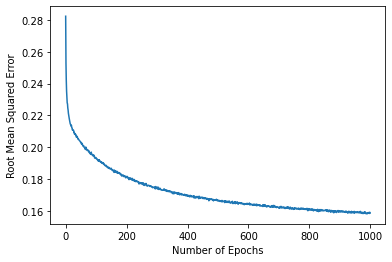

In [41]:
# Plot errors with respect to number of epochs
plt.plot(errors)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Epochs')

In [42]:
# Selecting the input user
inputUser = [trX[850]]

# Feed in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [59]:
# We can then list the 25 most recommended movies for our mock user by sorting it by their scores given by our model
scored_movies_df_850 = movies_df
scored_movies_df_850["Recommendation Score"] = rec[0]
print("\n")
print(scored_movies_df_850.sort_values(["Recommendation Score"], ascending=False).head(100))

# Now we recommend some movies that the user has not yet watched
print("\n")
print(merged_df.iloc[850])

# Now we can find all the movies that our mock user has watched before
movies_df_850 = merged_df[merged_df['user_id'] == 159]

# We merge all the movies that our mock users has watched with the predicted scores based on his historical data
merged_df_850 = scored_movies_df_850.merge(movies_df_850, on='movie_id', how='outer')
merged_df_850 = merged_df_850.drop('List Index_y', axis=1).drop('user_id', axis=1)
print("\n")
print(merged_df_850.sort_values(["Recommendation Score"], ascending=False).head(25))



      movie_id                                        movie_title  \
301        302                           L.A. Confidential (1997)   
309        310                              Rainmaker, The (1997)   
298        299                                     Hoodlum (1997)   
222        223                                 Sling Blade (1996)   
10          11                               Seven (Se7en) (1995)   
171        172                    Empire Strikes Back, The (1980)   
272        273                                        Heat (1995)   
345        346                                Jackie Brown (1997)   
1142      1143                                  Hard Eight (1996)   
181        182                                  GoodFellas (1990)   
914        915                              Primary Colors (1998)   
271        272                           Good Will Hunting (1997)   
55          56                                Pulp Fiction (1994)   
404        405                  

In [86]:
re = merged_df_850.sort_values(["Recommendation Score"], ascending=False).head(25)

In [91]:
correct_re = len(re[re['rating'] >= 3])/25

In [92]:
correct_re

0.28

In [96]:
inputUser

[[0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0.8,
  0.8,
  0.6,
  1.0,
  0.8,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  1.0,
  0.8,
  0,
  0,
  0,
  0.8,
  0,
  0,
  0,
  0.8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.8,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0.6,
  0,
  0,
  0.8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0.8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.8,
  0,
  0.6,
  0.2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.8,
  0.4,
  0.8,
  0,
  0.8,
  0,
  1.0,
  0.8,
  0.8,
  0,
  0,
  0.8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0.8,
  0,
  0,
  0,
  0,
  0,
  0.6,
  0,
  0,
  0,
  0.8,
  0,
  0.6,
  1.0,
  0.6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  1.0,
  0,
  0.8,
  0,
  0,
  0,
  1.0,
  0,
  1.0,
  0,